<table>
    <tr>
        <td style="text-align:left">
            <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9ItLTT_F-3Q30cu7ZCCoKmuFGBt22pe7pNA" alt="Logo Universidad" width="300"/>
        </td>
        <td>
            Departamento de Ciencias de la Computación y de la Decisión<br>
            Facultad de Minas<br>
            Universidad Nacional de Colombia<br>
            Optimizacion e IA 2024-2S<br><br>
            Docente: Maria Constanza Torres Madronero<br>
            <br>
            Contribuciones a la guia por: <br>
            - Deimer Miranda Montoya (2023)<br>
            - Luis Fernando Becerra Monsalve (2024)
        </td>    
        </td>    
    </tr>
</table>

### Clustering
Una tarea frecuente en aprendizaje de máquinas no supervisado es el agrupamiento o clustering. Estas técnicas permiten descubrir relaciones o patrones ocultos en los datos analizados. Existen diferentes métodos de agrupamiento, destacándose Kmeans por su simplicidad. En esta práctica compararemos Kmeans con técnicas de clustering que emplean métodos metaheuristicos como GA, PSO y ACO.

Primero generaremos una nube de datos para comparar los diferentes algoritmos. Para esto usaremos nuevamente herramientas disponibles en la librería sklearn.

In [1]:
#Importar librerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

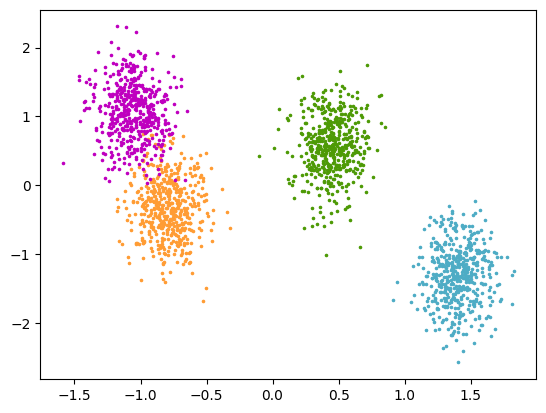

In [6]:
#Generacion de nubes de puntos
num_cluster = 4
n_samples = 2000
X, y_true = make_blobs(
    n_samples=n_samples,
    centers=num_cluster,
    n_features=2,
    random_state=37,
)

#Repetir con random_state=2
#Repetir con random_state=37 y num_cluster=5
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

#Importante: normalizar los datos

#Visualizacion de los datos
colors = ["#4EACC5", "#FF9C34", "#4E9A06", 'm']
for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker=".", s=10)

# Kmeans
Para esta práctica usaremos la implementación clásica de Kmeans empleando el método disponible en la librería sklearn.

In [8]:
####
kmeans = KMeans(
    n_clusters=num_cluster,
    init='random',
    n_init=1,
)

# Correr
kmeans.fit(X)

KMeans(init='random', n_clusters=4, n_init=1)

***Coeficiente de silueta***. Vamos a usar el [coeficiente de silueta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) como métrica de desempeño de los algoritmos de clustering. Existen diferentes métricas para esto, como la suma de la distancia al cuadrado de cada punto a su centroide. Sin embargo, el coeficiente de silueta no solo tiene en cuenta la distancia intra-cluster (distancia de cada punto al centro del clúster: a), sino también la distancia al clúster más cercano (b). El coeficiente de silueta para una muestra está dado por (b - a) / max(a, b). El mejor valor que se puede obtener es 1 y el peor -1. Valores cercanos a 0 indican clústeres que se sobreponen. Valores negativos indican una mala asignación de muestras a los clústeres, dado que existe un clúster más cercano o simular a ciertas muestras.

In [9]:
#Calculo del coeficiente de silueta
score = silhouette_score(
    X,
    kmeans.labels_,
)
print("Coeff Silueta para Kmeans: = ", score)

Coeff Silueta para Kmeans: =  0.6590880881097134


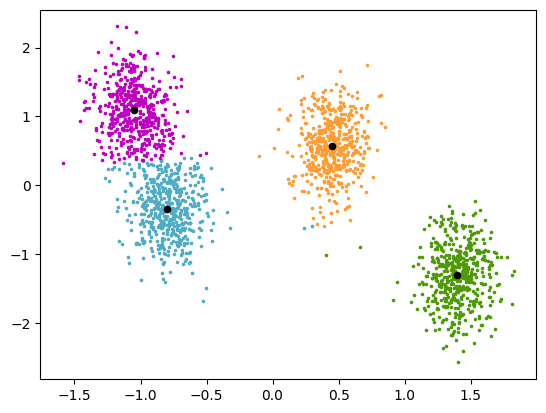

In [10]:
#Grafica de los cluster y centroides obtenidos
for k, col in enumerate(colors):
    filtered = X[kmeans.labels_==k]
    plt.scatter(filtered[:, 0], filtered[:, 1], c=col, marker=".", s=10)
    plt.scatter(kmeans.cluster_centers_[k, 0], kmeans.cluster_centers_[k, 1], c="black", marker="o", s=20)

### Algoritmo Genético
Vamos a usar la libreria PyGAD para realizar el proceso de clustering.

In [11]:
#Importar libreria pygad
import pygad

In [13]:
#Paso 1: Definire funcion fitness (funcion de aptitud)
#solution: arreglo con los centroides del cluster
#solution = [c1(x) c1(x) c2(x) c2(y)... cn(x) cn(y)]

def fitness_func(ga_instance, solution, solution_idx):
    global X, num_cluster
    k=0
    distance = np.zeros([n_samples, num_cluster])

    # Agrupar los datos al centroide más cercano
    for i in np.arange(0, (num_cluster)*2, 2):
        centroid = np.array([solution[i], solution[i+1]])
        distance[:, k] = np.square(np.sum(np.power(X - centroid, 2), axis = 1, ))
        k=k+1
    
    # Seleccionar la distancia más cercana, es decir, al clúster más cercano
    solution_inx = distance.argmin(axis=1)
    fitness = silhouette_score(X, solution_inx)

    return fitness

In [15]:
#Paso 2: Preparamos los parametros para correr el algoritmo genetico
num_generations = 50
num_parents_mating = 10
fitness_function = fitness_func
sol_per_pop = 20
#Numero de genes en la solucion
num_genes = num_cluster*2
#Rangos iniciales para la poblacion inicial
init_range_low = -1
init_range_high = 1
#Metodo para la seleccion de padres
#"rws": Ruleta
#"tournament": Torneo
parent_selection_type = "rws"
keep_parents = 5
crossover_type = "single_point"
crossover_probability=0.8
mutation_type = "random"
mutation_probability = 0.1

In [16]:
#Instanciar el Algoritmo
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       crossover_probability = crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability)

In [17]:
#Corremos el algoritmo
ga_instance.run()

In [18]:
#Extraemos la mejor solucion
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")


Parameters of the best solution : [ 0.46919122  0.54074942 -0.70812838 -0.48896978  1.40594025 -0.09310121
 -0.9957837   1.25606736]
Fitness value of the best solution = 0.6586681159197995


/Users/scuartasr/Documents/Maestría/Optimización/Clases/genet/.venv/lib/python3.11/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


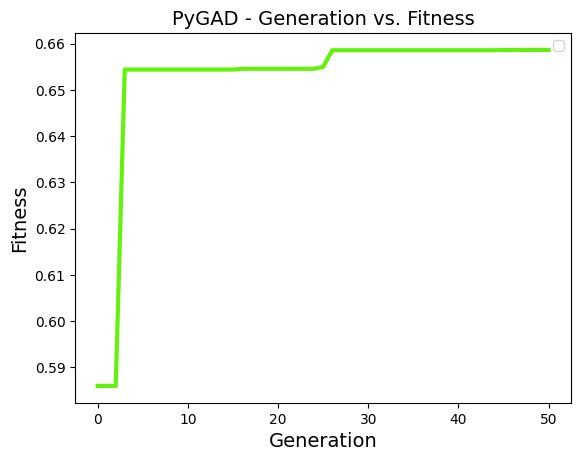

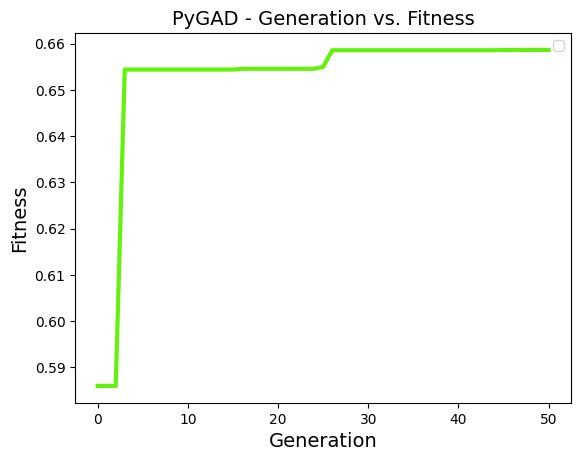

In [19]:
ga_instance.plot_fitness()

In [20]:
#Obtenemos los cluster asociados a cada muestra
distance = np.zeros([n_samples,num_cluster])
k=0
for i in np.arange(0,(num_cluster)*2,2):
  centroid = np.array([solution[i], solution[i+1]])
  distance[:,k] = np.square(np.sum(np.power(X - centroid, 2), axis=1))
  k=k+1
GA_labels=distance.argmin(axis=1)

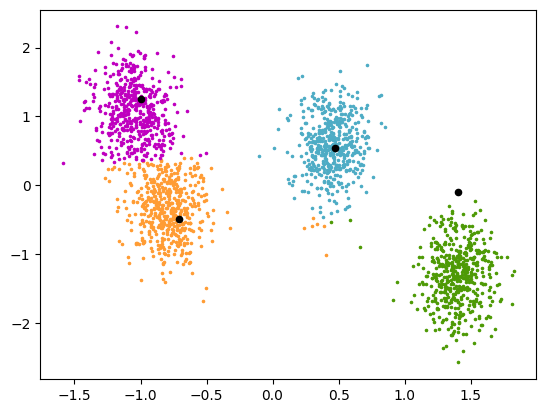

In [21]:
#Mostrar clusters
i=0
for k, col in enumerate(colors):
    filtered = X[GA_labels==k]
    plt.scatter(filtered[:, 0], filtered[:, 1], c=col, marker=".", s=10)
    plt.scatter(solution[i], solution[i+1], c="black", marker="o", s=20)
    i+=2